In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dane
## MNIST

In [321]:
from keras.datasets import mnist

In [322]:
(mnist_X_train, mnist_y_train),(_,_) = mnist.load_data()
mnist_X_train = mnist_X_train.reshape(60000, 28*28)

rng = np.random.default_rng(seed=44)
idx = rng.choice(60000, size=6000, replace=False)

mnist_X_train = mnist_X_train[idx]
mnist_y_train = mnist_y_train[idx]

Niestety implementacja nie jest zwektoryzowana, przez co nie jestem w stanie przeprowadzić eksperymentu na pełnym zbiorze (60 000 obserwacji). Dalsze eksperymenty będą przeprowadzona na próbce 6 000 obserwacji (10% oryginalnego zbioru).

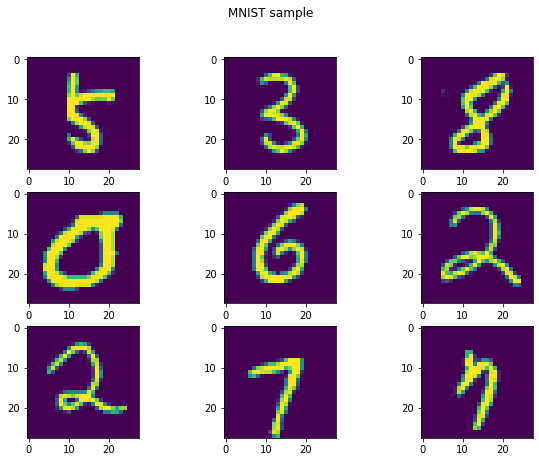

In [323]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(10,7)
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(mnist_X_train[i*3+j].reshape(28,28))
fig.suptitle("MNIST sample")
plt.show()

In [324]:
mnist_y_train[0:9]

array([5, 3, 8, 0, 6, 2, 2, 7, 7], dtype=uint8)

In [325]:
mnist_split = {
    category: np.array(
        mnist_X_train[mnist_y_train == category]
    )
    for category in np.unique(mnist_y_train)
}

In [326]:
{k: len(v) for (k,v) in mnist_split.items()}

{0: 577,
 1: 698,
 2: 621,
 3: 609,
 4: 583,
 5: 522,
 6: 578,
 7: 665,
 8: 583,
 9: 564}

## UCI Human Activity Recognition

In [290]:
ucihar_X_train = np.array(pd.read_csv("LAB2_DANE/UCI_X_train.txt", header=None, delim_whitespace=True))
ucihar_y_train = np.array(pd.read_csv("LAB2_DANE/UCI_y_train.txt", header=None)).flatten()
ucihar_X_train.shape

(7352, 561)

In [291]:
from sklearn.decomposition import PCA

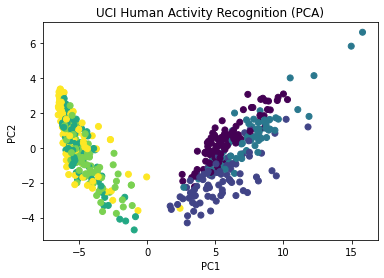

In [297]:
ucihar_pca = PCA(n_components=2)
ucihar_pca.fit(ucihar_X_train)
ucihar_reduced = ucihar_pca.transform(ucihar_X_train)
ucihar_sample_idx = rng.choice(ucihar_reduced.shape[0], size=600)
ucihar_reduced_sample = ucihar_reduced[ucihar_sample_idx]
ucihar_sample_label = ucihar_y_train[ucihar_sample_idx]
plt.scatter(
    ucihar_reduced_sample[:, 0],
    ucihar_reduced_sample[:, 1],
    c=ucihar_sample_label
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("UCI Human Activity Recognition (PCA)")
plt.show()

In [294]:
ucihar_split = {
    category: np.array(
        ucihar_X_train[ucihar_y_train == category]
    )
    for category in np.unique(ucihar_y_train)
}

In [295]:
{k: len(v) for (k,v) in ucihar_split.items()}

{1: 1226, 2: 1073, 3: 986, 4: 1286, 5: 1374, 6: 1407}

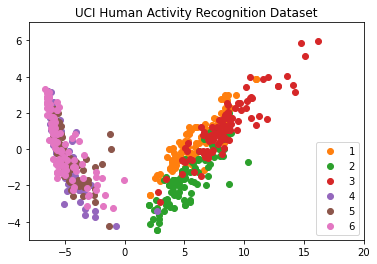

In [320]:
for cluster, data in sorted(ucihar_split.items()):
    sample_idx = rng.choice(data.shape[0], size=100)
    plt.scatter(
        ucihar_pca.transform(data[sample_idx])[:, 0],
        ucihar_pca.transform(data[sample_idx])[:, 1],
        c="C"+str(cluster),
        label=str(cluster)
    )
plt.ylim((-5, 7))
plt.xlim((-8, 20))
plt.legend()
plt.title("UCI Human Activity Recognition Dataset")
plt.show()

# Sieć Kohonena
## Kod

In [5]:
def distance_hexgrid(x, y):
    if (x[1] - y[1]) % 2 == 0:
        return distance_euclidean(np.array(x), np.array(y))
    else:
        return distance_euclidean(
            np.array(x),
            np.array([y[0]-0.5, y[1]])
        )

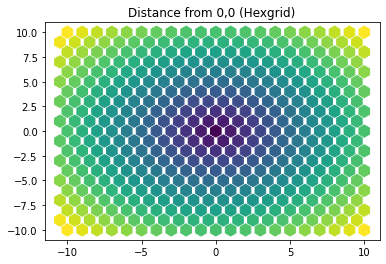

In [296]:
points_x = []
points_y = []
points_d = []
for i in range(-10, 11):
    for j in range(-10, 11):
        if j % 2 == 0:
            points_x.append(i)
        else:
            points_x.append(i-0.5)
        points_y.append(j)
        
        points_d.append(
            distance_hexgrid((0,0), (i,j))
        )

plt.scatter(
    points_x,
    points_y,
    c=points_d,
    s=150,
    marker="h"
)
plt.title("Distance from 0,0 (Hexgrid)")
plt.show()

In [329]:
def distance_euclidean(x, y):
    return np.sqrt(np.sum((x - y)**2))

def gauss_factory(metric):
    def gauss(n1, n2, t):
        d = metric(np.array(n1), np.array(n2))
        return np.exp(-d ** 2)
    return gauss

def mexican_factory(metric):
    def mexican(n1, n2, t):
        dt = t * metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- dt**2)
        mult_part = (2 - 4 * dt**2)
        return - mult_part * exp_part
    return mexican

def mexican_factory_no_t(metric):
    def mexican(n1, n2, t):
        d = metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- d**2)
        mult_part = (2 - 4 * d**2)
        return - mult_part * exp_part
    return mexican

def mexican_factory_scale_no_t(metric, scale):
    def mexican(n1, n2, t):
        d = scale * metric(np.array(n1), np.array(n2))
        exp_part = np.exp(- d**2)
        mult_part = (2 - 4 * d**2)
        return - mult_part * exp_part
    return mexican

def exp_slowdown_factory(rate):
    def slowdown(t):
        return np.exp(-t/rate)
    return slowdown

def pow_slowdown_factory(rate):
    def slowdown(t):
        return rate ** t
    return slowdown

def const_slowdown_factory(rate):
    def slowdown(t):
        return rate
    return slowdown


In [332]:
class KOH:
    def __init__(self,
                 data,
                 output_shape,
                 /,
                 metric = distance_euclidean,
                 neighborhood = gauss_factory(distance_euclidean),
                 slowdown_function = exp_slowdown_factory(0.1), #alpha
                 evaluation_data = None, # split
                ):
        self.data = data.copy()
        self.input_shape = data.shape[1]
        self.output_shape = output_shape
        self.weights = np.random.random(
            (self.input_shape,) + self.output_shape
        )
        self.metric = metric
        self.neighborhood = neighborhood
        self.slowdown_function = slowdown_function
        self.evaluation_data = evaluation_data
        
    def train(self, num_epoch):
        for t in range(num_epoch):
            print(f"Epoch: {t+1: <10}", end="\r")
            
            np.random.shuffle(self.data)
            for obs_num, obs in enumerate(self.data):
                # argmin
                ijstar = min([
                    (self.metric(self.weights[:, i, j], obs), (i,j))
                    for i in range(self.output_shape[0])
                    for j in range(self.output_shape[1])
                ])[1]
                
                # update weights
                for i in range(self.output_shape[0]):
                    for j in range(self.output_shape[1]):
                        distance = self.neighborhood((i,j), ijstar, t) 
                        a = self.slowdown_function(t)
                        diff = (obs - self.weights[:, i, j])
                        self.weights[:, i, j] += distance * a * diff
                        
    def apply(self, obs):
        return [self.weights[i, :, :] * el for i, el in enumerate(obs)]
    
    def apply_aggregate(self, data):
        return np.sum([
            np.sum(
                self.apply(obs),
                axis=0
            ) 
            for obs in data],
            axis=0
        )
    
    def plot_evaluate(self, nrow=2, ncol=3, figsize=(10,7), plot_param={}):
        classes = sorted(self.evaluation_data.keys())
        fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
        axs = axs.reshape(nrow, ncol)
        
        rowcol_generator = ((r,c) for r in range(nrow) for c in range(ncol))
        for cur_class, (row, col) in zip(classes, rowcol_generator):
            axs[row,col].imshow(
                self.apply_aggregate(
                    self.evaluation_data[cur_class]
                ),
                **plot_param
            )
            axs[row,col].axis("off")
            axs[row, col].set_title(f"Cluster {cur_class}")
        return fig, axs
    
    def plot_evaluate_hex(self, nrow=2, ncol=3, figsize=(10,7), plot_param={}):
        classes = sorted(self.evaluation_data.keys())
        
        fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
        axs = axs.reshape(nrow, ncol)
        rowcol_generator = ((r,c) for r in range(nrow) for c in range(ncol))
        for cur_class, (row, col) in zip(classes, rowcol_generator):
            axs[row,col].scatter([
                    i - (0 if j % 2 == 0 else 0.5) 
                    for i in range(self.output_shape[0]) 
                    for j in range(self.output_shape[1])
                ],
                [
                    j 
                    for i in range(self.output_shape[0]) 
                    for j in range(self.output_shape[1])
                ],
                c=self.apply_aggregate(
                    self.evaluation_data[cur_class]
                ),
                **plot_param
            )
            axs[row,col].axis("off")
            axs[row, col].set_title(f"Cluster {cur_class}")
        return fig, axs
    
    def get_neuron_coordinates(self):
        neuron_count = self.output_shape[0] * self.output_shape[1]
        return self.weights.T.reshape(neuron_count, self.input_shape)
    
    def plot_neurons_2d(self):
        neuron_coords = self.get_neuron_coordinates()
        fig, ax = plt.subplots(figsize=(5, 3.5), dpi=125)
        ax.scatter(
            neuron_coords[:, 0],
            neuron_coords[:, 1]
        )
        return fig, ax
    
    def classify(self, input_data):
        return np.array([
            np.argmin([
                self.metric(neuron, obs)
                for neuron in self.get_neuron_coordinates()
            ])
            for obs in input_data
        ])
    
    def v_measure(self, input_data, actual):
        from sklearn.metrics import v_measure_score
        
        return v_measure_score(
            self.classify(input_data), 
            actual
        )

In [337]:
mnist_hex_gauss = KOH(
    mnist_X_train,
    (20,20),
    neighborhood=gauss_factory(distance_hexgrid),
    evaluation_data=mnist_split
)
mnist_hex_mexican = KOH(
    mnist_X_train,
    (20,20),
    neighborhood=mexican_factory_no_t
    (distance_hexgrid),
    evaluation_data=mnist_split
)
mnist_square_gauss = KOH(
    mnist_X_train,
    (20,20),
    neighborhood=gauss_factory(distance_euclidean),
    evaluation_data=mnist_split
)
mnist_square_mexican = KOH(
    mnist_X_train,
    (20,20),
    neighborhood=mexican_factory_no_t(distance_euclidean),
    evaluation_data=mnist_split
)

mnist_nets = [mnist_hex_gauss, mnist_hex_mexican, mnist_square_gauss, mnist_square_mexican]
mnist_nets_names = [
    "Hexagonal Gauss Kohonen Network MNIST",
    "Hexagonal Mexican Hat Kohonen Network MNIST",
    "Square Gauss Kohonen Network MNIST",
    "Square Mexican Hat Kohonen Network MNIST",
]

Training Hexagonal Gauss Kohonen Network MNIST
Epoch: 10        
Hexagonal Gauss Kohonen Network MNIST v-score: 0.4644425962412216


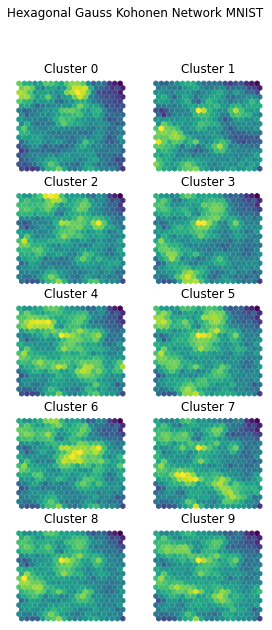

Training Hexagonal Mexican Hat Kohonen Network MNIST
Epoch: 10        
Hexagonal Mexican Hat Kohonen Network MNIST v-score: 0.43602155845557045


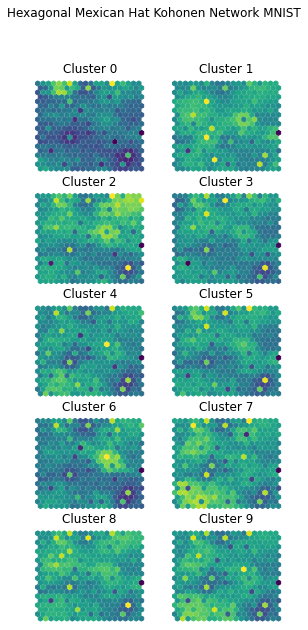

Training Square Gauss Kohonen Network MNIST
Epoch: 10        
Square Gauss Kohonen Network MNIST v-score: 0.4573454003479593


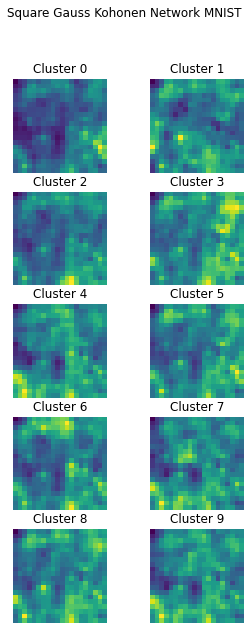

Training Square Mexican Hat Kohonen Network MNIST
Epoch: 10        
Square Mexican Hat Kohonen Network MNIST v-score: 0.4274993545269435


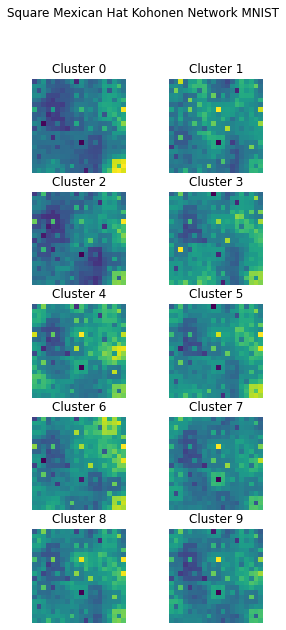

CPU times: user 1h 19min 51s, sys: 10.1 s, total: 1h 20min 2s
Wall time: 1h 20min 27s


In [338]:
%%time
mnist_v_scores = {}
for net, net_name in zip(mnist_nets, mnist_nets_names):
    print(f"Training {net_name}")
    net.train(10)
    v_score = net.v_measure(mnist_X_train, mnist_y_train)
    mnist_v_scores[net_name] = v_score
    print(f"\n{net_name} v-score: {v_score}")
    if net_name[0] == "H":
        fig, axs = net.plot_evaluate_hex(
            nrow=5, 
            ncol=2, 
            figsize=(4.5,10), 
            plot_param={
                "s": 25,
                "marker": "h"
            }
        )
    else:
        fig, axs = net.plot_evaluate(
            nrow=5,
            ncol=2, 
            figsize=(4.5, 10)
        )
    fig.suptitle(net_name)
    plt.show()

In [339]:
ucihar_hex_gauss = KOH(
    ucihar_X_train,
    (20,20),
    neighborhood=gauss_factory(distance_hexgrid),
    evaluation_data=ucihar_split
)
ucihar_hex_mexican = KOH(
    ucihar_X_train,
    (20,20),
    neighborhood=mexican_factory_no_t
    (distance_hexgrid),
    evaluation_data=ucihar_split
)
ucihar_square_gauss = KOH(
    ucihar_X_train,
    (20,20),
    neighborhood=gauss_factory(distance_euclidean),
    evaluation_data=ucihar_split
)
ucihar_square_mexican = KOH(
    ucihar_X_train,
    (20,20),
    neighborhood=mexican_factory_no_t(distance_euclidean),
    evaluation_data=ucihar_split
)

ucihar_nets = [ucihar_hex_gauss, ucihar_hex_mexican, ucihar_square_gauss, ucihar_square_mexican]
ucihar_nets_names = [
    "Hexagonal Gauss Kohonen Network Human Activity Recognition Dataset",
    "Hexagonal Mexican Hat Kohonen Network Human Activity Recognition Dataset",
    "Square Gauss Kohonen Network Human Activity Recognition Dataset",
    "Square Mexican Hat Kohonen Network Human Activity Recognition Dataset",
]

Training Hexagonal Gauss Kohonen Network Human Activity Recognition Dataset
Epoch: 10        
Hexagonal Gauss Kohonen Network Human Activity Recognition Dataset v-score: 0.41178592624190763


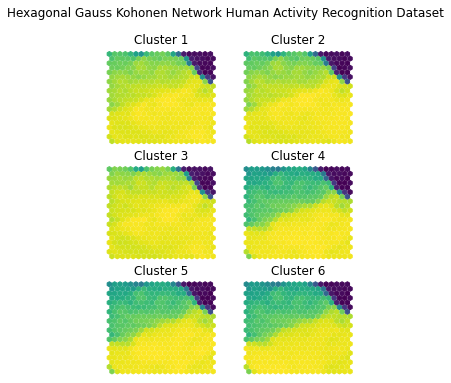

Training Hexagonal Mexican Hat Kohonen Network Human Activity Recognition Dataset
Epoch: 10        
Hexagonal Mexican Hat Kohonen Network Human Activity Recognition Dataset v-score: 0.41735518969145374


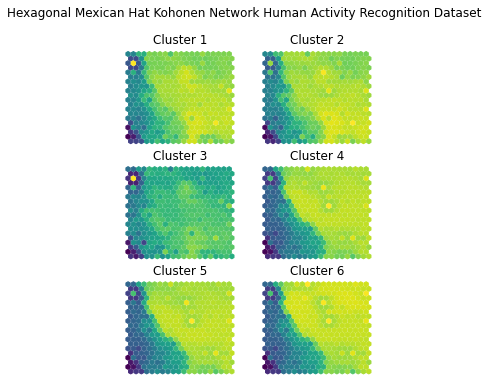

Training Square Gauss Kohonen Network Human Activity Recognition Dataset
Epoch: 10        
Square Gauss Kohonen Network Human Activity Recognition Dataset v-score: 0.43739511014613064


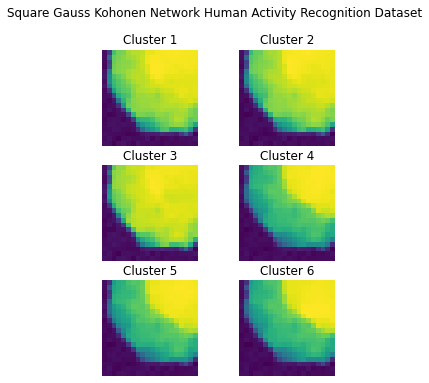

Training Square Mexican Hat Kohonen Network Human Activity Recognition Dataset
Epoch: 10        
Square Mexican Hat Kohonen Network Human Activity Recognition Dataset v-score: 0.4185156361098219


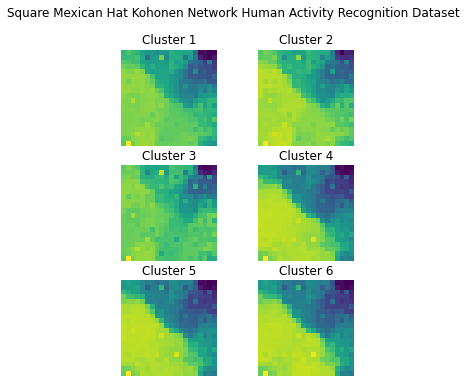

CPU times: user 1h 20min 31s, sys: 5.38 s, total: 1h 20min 36s
Wall time: 1h 20min 39s


In [340]:
%%time
ucihar_v_scores = {}
for net, net_name in zip(ucihar_nets, ucihar_nets_names):
    print(f"Training {net_name}")
    net.train(10)
    v_score = net.v_measure(ucihar_X_train, ucihar_y_train)
    ucihar_v_scores[net_name] = v_score
    print(f"\n{net_name} v-score: {v_score}")
    if net_name[0] == "H":
        fig, axs = net.plot_evaluate_hex(
            nrow=3, 
            ncol=2, 
            figsize=(4.5,6), 
            plot_param={
                "s": 25,
                "marker": "h"
            }
        )
    else:
        fig, axs = net.plot_evaluate(
            nrow=3,
            ncol=2, 
            figsize=(4.5, 6)
        )
        
    fig.suptitle(net_name)
    plt.show()